In [4]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO
import os
import pandas as pd
from pathlib import Path

def extract_text_from_pdf(pdf_path):
    # Create resource manager
    rsrcmgr = PDFResourceManager()
    # Create string buffer
    retstr = StringIO()
    # Set parameters for analysis
    laparams = LAParams()
    # Create text converter
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)

    # Open PDF file
    with open(pdf_path, 'rb') as fp:
        # Create interpreter
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        # Process each page
        for page in PDFPage.get_pages(fp):
            interpreter.process_page(page)

    # Get text
    text = retstr.getvalue()

    # Close everything
    device.close()
    retstr.close()

    return text

# Set up the folder path
folder_path = r"/content/cia2"
folder = Path(folder_path)

data = []
filenames = []

# Process each PDF file
for file in folder.glob("*.pdf"):
    try:
        # Extract text from the PDF
        text = extract_text_from_pdf(str(file))

        # Only add non-empty texts
        if text.strip():
            data.append(text)
            filenames.append(file.name)
        else:
            print(f"Warning: No text extracted from {file.name}")

    except Exception as e:
        print(f"Error processing {file.name}: {str(e)}")

# Create DataFrame with both filename and text
df = pd.DataFrame({
    'filename': filenames,
    'article_text': data
})

# Basic statistics
print(f"\nProcessed {len(filenames)} PDF files")
print(f"Successfully extracted text from {len(data)} files")

# Optional: Save to CSV
# df.to_csv('extracted_texts.csv', index=False)


Processed 50 PDF files
Successfully extracted text from 50 files


In [7]:
import re
# Expand Contraction
from contractions import contractions_dict
# Function to expand contractions using the contractions_dict
def expand_contractions(text):
    # Regular expression pattern to match contractions
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        expanded = contractions_dict.get(match.lower())
        return expanded

    expanded_text = contractions_pattern.sub(expand_match, text)
    return expanded_text

# Apply the expand_contractions function to the "content" column
df['article_text'] = df['article_text'].apply(expand_contractions)


In [11]:
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
from string import punctuation
from collections import Counter

def clean_text(text):
    """
    Clean and preprocess the text with special handling for journal-specific patterns
    """
    # 1. Remove standard journal patterns
    text = re.sub(r'©\s*2024\s*the authors?', '', text, flags=re.IGNORECASE)
    text = re.sub(r'water policy vol \d+ no \d+', '', text, flags=re.IGNORECASE)
    text = re.sub(r'doi:\s*10\.\d+/[\w\.]+', '', text)
    text = re.sub(r'wp\s*202[34]\s*\d+', '', text)

    # 2. Remove PDF artifacts and special characters
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\x0c', ' ', text)
    text = re.sub(r'Downloaded from.*?2024', '', text)

    # 3. Remove URLs and DOIs
    text = re.sub(r'http\S+|https\S+', '', text)

    # 4. Remove references section
    text = re.sub(r'References.*', '', text, flags=re.DOTALL)

    # 5. Remove emails and institutional affiliations
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', text)
    text = re.sub(r'[a-zA-Z ]+University.*?\n', '', text, flags=re.MULTILINE)

    # 6. Remove parenthetical numbers and citations
    text = re.sub(r'\([^)]*\d+[^)]*\)', '', text)

    # 7. Basic text cleaning
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

def preprocess_text(text, custom_stopwords=None):
    """
    Preprocess text with custom stopwords
    """
    # Define custom stopwords specific to your journal articles
    journal_specific_stopwords = {
        'water', 'policy', 'vol', 'doi', 'wp', 'authors', 'author',
        'journal', 'article', 'research', 'study', 'analysis', 'data',
        'results', 'method', 'methods', 'figure', 'table', 'section',
        'introduction', 'conclusion', 'abstract', 'references'
    }

    # Combine with standard stopwords
    stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    stop_words.update(journal_specific_stopwords)

    # 1. Tokenization
    tokens = word_tokenize(text)

    # 2. Remove stopwords and custom words
    tokens = [token for token in tokens if token not in stop_words]

    # 3. Remove short words and numbers
    tokens = [token for token in tokens if len(token) > 2 and not token.isnumeric()]

    return tokens

# Function to analyze text patterns
def analyze_common_patterns(texts):
    """
    Analyze common patterns across texts to identify potential additional stopwords
    """
    all_words = []
    for text in texts:
        words = word_tokenize(text.lower())
        all_words.extend(words)

    word_freq = Counter(all_words)
    print("\nMost common words across all texts:")
    return dict(word_freq.most_common(20))

# Apply the cleaning and preprocessing
df['clean_text'] = df['article_text'].apply(clean_text)

# Analyze common patterns first
common_patterns = analyze_common_patterns(df['clean_text'])
print(common_patterns)

# Add any additional stopwords based on the analysis
additional_stopwords = set()  # Add words here based on the analysis output

# Apply preprocessing with custom stopwords
df['tokens'] = df['clean_text'].apply(lambda x: preprocess_text(x, additional_stopwords))

# Display results
print("\nOriginal text length:", len(df['article_text'][0]))
print("Cleaned text length:", len(df['clean_text'][0]))
print("Number of tokens:", len(df['tokens'][0]))

# Display first few sentences of cleaned text
print("\nFirst 200 characters of cleaned text:")
print(df['clean_text'][0][:200])

# Display first 20 tokens
print("\nFirst 20 tokens:")
print(df['tokens'][0][:20])

# Create word frequency distribution
from collections import Counter
word_freq = Counter([word for tokens in df['tokens'] for word in tokens])
print("\nMost common terms after cleaning:")
print(dict(word_freq.most_common(20)))


Most common words across all texts:
{'the': 24360, 'of': 14945, 'and': 13649, 'in': 9659, 'water': 9214, 'to': 8225, 'a': 6545, 'for': 4154, 'is': 3829, 'on': 2468, 'as': 2415, 'that': 2388, '0': 2269, '1': 2150, 'are': 2056, 'with': 2033, 'this': 2022, 'by': 1879, 'from': 1754, 's': 1742}

Original text length: 70788
Cleaned text length: 58518
Number of tokens: 5081

First 200 characters of cleaned text:
189 challenges and opportunities for ntralised water technologies in scotland a jill robbie b william t sloan elizabeth lawson a newcastle university centre for water school of engineering devonshire 

First 20 tokens:
['challenges', 'opportunities', 'ntralised', 'technologies', 'scotland', 'jill', 'robbie', 'william', 'sloan', 'elizabeth', 'lawson', 'newcastle', 'university', 'centre', 'school', 'engineering', 'devonshire', 'building', 'newcastle', 'university']

Most common terms after cleaning:
{'management': 1140, 'development': 868, 'use': 846, 'resources': 828, 'public': 740, '

In [10]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [12]:
#Lemmitization
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_text(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Apply the lemmatize_text function to the "tokenized_content" column
df['lemmatized_content'] = df['tokens'].apply(lemmatize_text)


#time.sleep(1)
print('\n')
print('\n')
print('lemmatized_content')
# Display the lemmatized content of the first row
df['lemmatized_content'][0][:30]

[nltk_data] Downloading package wordnet to /root/nltk_data...






lemmatized_content


['challenge',
 'opportunity',
 'ntralised',
 'technology',
 'scotland',
 'jill',
 'robbie',
 'william',
 'sloan',
 'elizabeth',
 'lawson',
 'newcastle',
 'university',
 'centre',
 'school',
 'engineering',
 'devonshire',
 'building',
 'newcastle',
 'university',
 'newcastle',
 'upon',
 'tyne',
 'ne1',
 '7ru',
 'united',
 'kingdom',
 'school',
 'law',
 'stair']

In [15]:
#For data preprocessing
import time
from contractions import contractions_dict
import re
from collections import Counter
from wordcloud import STOPWORDS
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#ML model Implimentation
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

In [16]:
# Vectorizing Text


# Convert the list of lemmatized tokens into strings
lemmatized_text = [' '.join(tokens) for tokens in df['lemmatized_content']]

# Initialize a CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the lemmatized text data
tfidf_matrix = vectorizer.fit_transform(lemmatized_text)

# Display the shape of the resulting matrix
print("Shape of the vectorized matrix:", tfidf_matrix.shape)

Shape of the vectorized matrix: (50, 7670)


In [34]:
# ML Model - 1 Implementation

# Convert the list of lemmatized tokens into a list of lists
lemmatized_text = [tokens for tokens in df['lemmatized_content']]

# Create a dictionary of terms with term frequency filtering
dictionary = corpora.Dictionary(lemmatized_text)
dictionary.filter_extremes(no_below=3, no_above=0.85)

# Fit the Algorithm

# Create a Gensim corpus
corpus_gensim = [dictionary.doc2bow(text) for text in lemmatized_text]

# Build LDA model
num_topics = 5
lda_model = LdaModel(corpus_gensim, num_topics=num_topics, id2word=dictionary, passes=20, random_state= 40)

print('\n')
print('\n')
# Calculate coherence score
coherence_model = CoherenceModel(model=lda_model, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# Print coherence score
print(f"Coherence Score: {coherence_score:.4f}")


# Print topics and associated words
for topic_id, topic_words in lda_model.print_topics():
    print('\n')
    print(f"Topic {topic_id}: {topic_words}")





Coherence Score: 0.3879


Topic 0: 0.011*"community" + 0.008*"capacity" + 0.007*"local" + 0.007*"service" + 0.005*"governance" + 0.005*"drinking" + 0.005*"organization" + 0.005*"trust" + 0.005*"rural" + 0.004*"sector"


Topic 1: 0.018*"governance" + 0.010*"sludge" + 0.009*"strategy" + 0.009*"actor" + 0.008*"policy" + 0.008*"city" + 0.007*"measure" + 0.006*"river" + 0.006*"sewage" + 0.006*"local"


Topic 2: 0.019*"river" + 0.013*"basin" + 0.009*"china" + 0.009*"pollution" + 0.007*"infrastructure" + 0.007*"climate" + 0.007*"sion" + 0.007*"drought" + 0.007*"urban" + 0.006*"quality"


Topic 3: 0.021*"farmer" + 0.014*"irrigation" + 0.013*"technology" + 0.011*"agricultural" + 0.011*"saving" + 0.008*"drought" + 0.007*"model" + 0.007*"international" + 0.006*"law" + 0.006*"intention"


Topic 4: 0.010*"groundwater" + 0.008*"quality" + 0.007*"india" + 0.006*"ganga" + 0.006*"drinking" + 0.005*"household" + 0.004*"employment" + 0.004*"reuse" + 0.004*"point" + 0.004*"subsidy"


In [ ]:
#Define a grid of hyperparameters to search over
param_grid = {
    'num_topics': [4, 5, 6, 7],
    'passes': [10, 20, 30]
}

best_coherence_score = -1
best_lda_model = None

# Perform grid search
for params in ParameterGrid(param_grid):
    lda_model = LdaModel(corpus_gensim, id2word=dictionary, **params)
    coherence_model = CoherenceModel(model=lda_model, texts=lemmatized_text, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    if coherence_score > best_coherence_score:
        best_coherence_score = coherence_score
        best_lda_model = lda_model

print('\n')
print('\n')

# Print best hyperparameters and coherence score
print("Best Hyperparameters:", best_lda_model)
print('\n')
print(f"Best Coherence Score: {best_coherence_score:.4f}")

# Print topics and associated words for the best model
for topic_id, topic_words in best_lda_model.print_topics():
    print('\n')
    print(f"Topic {topic_id}: {topic_words}")





Best Hyperparameters: LdaModel<num_terms=5274, num_topics=4, decay=0.5, chunksize=2000>


Best Coherence Score: 0.4017


Topic 0: 0.015*"river" + 0.013*"groundwater" + 0.012*"basin" + 0.009*"quality" + 0.007*"pollution" + 0.006*"ganga" + 0.006*"india" + 0.005*"sludge" + 0.005*"lake" + 0.004*"treatment"


Topic 1: 0.019*"farmer" + 0.013*"technology" + 0.013*"irrigation" + 0.010*"saving" + 0.010*"agricultural" + 0.009*"household" + 0.007*"variable" + 0.007*"subsidy" + 0.006*"trust" + 0.006*"income"


Topic 2: 0.009*"community" + 0.008*"governance" + 0.007*"drought" + 0.007*"capacity" + 0.006*"climate" + 0.006*"local" + 0.006*"sion" + 0.006*"service" + 0.005*"actor" + 0.005*"international"


Topic 3: 0.009*"city" + 0.009*"china" + 0.007*"quality" + 0.007*"infrastructure" + 0.007*"policy" + 0.006*"urban" + 0.006*"governance" + 0.006*"measure" + 0.005*"river" + 0.005*"employment"


In [39]:
# ML Model - 2 Implementation

# Convert the list of lemmatized tokens into strings
lemmatized_text = [' '.join(tokens) for tokens in df['lemmatized_content']]

# Initialize a TF-IDF Vectorizer
vectorizer_final = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the lemmatized text data
tfidf_matrix = vectorizer_final.fit_transform(lemmatized_text)

# Get feature names
feature_names = vectorizer_final.get_feature_names_out()

# Initialize NMF model
num_topics = 4
nmf_model = NMF(n_components=num_topics, random_state=42)

# Fit the NMF model to the TF-IDF matrix
nmf_model.fit(tfidf_matrix)

print('\n')
# Print topics and associated words
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")
# Initialize CoherenceModel with c_v metric
coherence_model_nmf = CoherenceModel(topics=nmf_topics, texts=tokenized_text, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_nmf.get_coherence()

print(f"NMF Model Coherence Score: {coherence_score}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)




Topic 0: governance, capacity, actor, public, community, infrastructure, drought, local, sion, organization
Topic 1: farmer, saving, irrigation, intention, technology, agricultural, behavior, adoption, variable, matching
Topic 2: river, basin, ganga, pollution, lake, quality, groundwater, aquifer, china, surface
Topic 3: drinking, quality, household, community, india, supply, rural, sanitation, groundwater, health
NMF Model Coherence Score: 0.48874485462561956


In [23]:
from sklearn.decomposition import NMF
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import numpy as np

# Define the parameter grid
topic_range = range(2, 10)          # Adjust the range as needed
alpha_W_range = [0.1, 0.5, 1.0]     # Regularization for W matrix
l1_ratio_range = [0.0, 0.5, 1.0]    # Balance between L1 and L2 penalty

# Prepare tokenized text and dictionary for coherence model
tokenized_text = df['lemmatized_content'].tolist()
dictionary = Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# Track best score and parameters
best_coherence = 0
best_params = {}

# Grid search over parameters
for num_topics in topic_range:
    for alpha_W in alpha_W_range:
        for l1_ratio in l1_ratio_range:
            # Initialize and fit the NMF model
            nmf_model = NMF(n_components=num_topics, alpha_W=alpha_W, l1_ratio=l1_ratio, random_state=42)
            W = nmf_model.fit_transform(tfidf_matrix)
            H = nmf_model.components_

            # Extract topics from NMF model
            nmf_topics = []
            for topic in H:
                top_words_idx = topic.argsort()[:-10 - 1:-1]
                top_words = [feature_names[i] for i in top_words_idx]
                nmf_topics.append(top_words)

            # Compute coherence score
            coherence_model_nmf = CoherenceModel(topics=nmf_topics, texts=tokenized_text, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model_nmf.get_coherence()

            # Update best score and parameters if current is better
            if coherence_score > best_coherence:
                best_coherence = coherence_score
                best_params = {
                    'n_components': num_topics,
                    'alpha_W': alpha_W,
                    'l1_ratio': l1_ratio
                }

            print(f"Params: Topics={num_topics}, Alpha_W={alpha_W}, L1_ratio={l1_ratio} => Coherence: {coherence_score}")

print(f"\nBest Coherence Score: {best_coherence}")
print("Best Parameters:", best_params)


Params: Topics=2, Alpha_W=0.1, L1_ratio=0.0 => Coherence: 0.3470014105205765
Params: Topics=2, Alpha_W=0.1, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=2, Alpha_W=0.1, L1_ratio=1.0 => Coherence: 0.568257507009721
Params: Topics=2, Alpha_W=0.5, L1_ratio=0.0 => Coherence: 0.3470014105205765
Params: Topics=2, Alpha_W=0.5, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=2, Alpha_W=0.5, L1_ratio=1.0 => Coherence: 0.568257507009721
Params: Topics=2, Alpha_W=1.0, L1_ratio=0.0 => Coherence: 0.3470014105205765
Params: Topics=2, Alpha_W=1.0, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=2, Alpha_W=1.0, L1_ratio=1.0 => Coherence: 0.568257507009721
Params: Topics=3, Alpha_W=0.1, L1_ratio=0.0 => Coherence: 0.352896224986915
Params: Topics=3, Alpha_W=0.1, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=3, Alpha_W=0.1, L1_ratio=1.0 => Coherence: 0.6182549309912714
Params: Topics=3, Alpha_W=0.5, L1_ratio=0.0 => Coherence: 0.352896224986915
Params: Topics=3, Alpha_W=0.5, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=3, Alpha_W=0.5, L1_ratio=1.0 => Coherence: 0.6182549309912714
Params: Topics=3, Alpha_W=1.0, L1_ratio=0.0 => Coherence: 0.352896224986915
Params: Topics=3, Alpha_W=1.0, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=3, Alpha_W=1.0, L1_ratio=1.0 => Coherence: 0.6182549309912714
Params: Topics=4, Alpha_W=0.1, L1_ratio=0.0 => Coherence: 0.3511892884400938
Params: Topics=4, Alpha_W=0.1, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=4, Alpha_W=0.1, L1_ratio=1.0 => Coherence: 0.6008953240720019
Params: Topics=4, Alpha_W=0.5, L1_ratio=0.0 => Coherence: 0.3511892884400938
Params: Topics=4, Alpha_W=0.5, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=4, Alpha_W=0.5, L1_ratio=1.0 => Coherence: 0.6008953240720019
Params: Topics=4, Alpha_W=1.0, L1_ratio=0.0 => Coherence: 0.3511892884400938
Params: Topics=4, Alpha_W=1.0, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=4, Alpha_W=1.0, L1_ratio=1.0 => Coherence: 0.6008953240720019
Params: Topics=5, Alpha_W=0.1, L1_ratio=0.0 => Coherence: 0.3501651265120011
Params: Topics=5, Alpha_W=0.1, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=5, Alpha_W=0.1, L1_ratio=1.0 => Coherence: 0.5870217309505448
Params: Topics=5, Alpha_W=0.5, L1_ratio=0.0 => Coherence: 0.3501651265120011
Params: Topics=5, Alpha_W=0.5, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=5, Alpha_W=0.5, L1_ratio=1.0 => Coherence: 0.5870217309505448
Params: Topics=5, Alpha_W=1.0, L1_ratio=0.0 => Coherence: 0.3501651265120011
Params: Topics=5, Alpha_W=1.0, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=5, Alpha_W=1.0, L1_ratio=1.0 => Coherence: 0.5870217309505448
Params: Topics=6, Alpha_W=0.1, L1_ratio=0.0 => Coherence: 0.34948235189327265
Params: Topics=6, Alpha_W=0.1, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=6, Alpha_W=0.1, L1_ratio=1.0 => Coherence: 0.5761186888896369
Params: Topics=6, Alpha_W=0.5, L1_ratio=0.0 => Coherence: 0.34948235189327265
Params: Topics=6, Alpha_W=0.5, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=6, Alpha_W=0.5, L1_ratio=1.0 => Coherence: 0.5761186888896369
Params: Topics=6, Alpha_W=1.0, L1_ratio=0.0 => Coherence: 0.34948235189327265
Params: Topics=6, Alpha_W=1.0, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=6, Alpha_W=1.0, L1_ratio=1.0 => Coherence: 0.5761186888896369
Params: Topics=7, Alpha_W=0.1, L1_ratio=0.0 => Coherence: 0.3489946557370381
Params: Topics=7, Alpha_W=0.1, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=7, Alpha_W=0.1, L1_ratio=1.0 => Coherence: 0.5303652000926689
Params: Topics=7, Alpha_W=0.5, L1_ratio=0.0 => Coherence: 0.3489946557370381
Params: Topics=7, Alpha_W=0.5, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=7, Alpha_W=0.5, L1_ratio=1.0 => Coherence: 0.5303652000926689
Params: Topics=7, Alpha_W=1.0, L1_ratio=0.0 => Coherence: 0.3489946557370381
Params: Topics=7, Alpha_W=1.0, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=7, Alpha_W=1.0, L1_ratio=1.0 => Coherence: 0.5303652000926689
Params: Topics=8, Alpha_W=0.1, L1_ratio=0.0 => Coherence: 0.3486288836198622
Params: Topics=8, Alpha_W=0.1, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=8, Alpha_W=0.1, L1_ratio=1.0 => Coherence: 0.47319941189318326
Params: Topics=8, Alpha_W=0.5, L1_ratio=0.0 => Coherence: 0.3486288836198622
Params: Topics=8, Alpha_W=0.5, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=8, Alpha_W=0.5, L1_ratio=1.0 => Coherence: 0.47319941189318326
Params: Topics=8, Alpha_W=1.0, L1_ratio=0.0 => Coherence: 0.3486288836198622
Params: Topics=8, Alpha_W=1.0, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=8, Alpha_W=1.0, L1_ratio=1.0 => Coherence: 0.47319941189318326
Params: Topics=9, Alpha_W=0.1, L1_ratio=0.0 => Coherence: 0.35550358206666344
Params: Topics=9, Alpha_W=0.1, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=9, Alpha_W=0.1, L1_ratio=1.0 => Coherence: 0.4654063146198615
Params: Topics=9, Alpha_W=0.5, L1_ratio=0.0 => Coherence: 0.35550358206666344
Params: Topics=9, Alpha_W=0.5, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=9, Alpha_W=0.5, L1_ratio=1.0 => Coherence: 0.4654063146198615
Params: Topics=9, Alpha_W=1.0, L1_ratio=0.0 => Coherence: 0.35550358206666344
Params: Topics=9, Alpha_W=1.0, L1_ratio=0.5 => Coherence: 0.39899514168835193


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Params: Topics=9, Alpha_W=1.0, L1_ratio=1.0 => Coherence: 0.4654063146198615

Best Coherence Score: 0.6182549309912714
Best Parameters: {'n_components': 3, 'alpha_W': 0.1, 'l1_ratio': 1.0}


In [24]:
# Initialize NMF model with best parameters
best_nmf_model = NMF(n_components=3, alpha_W=0.1, l1_ratio=1.0, random_state=42)

# Fit the model on the TF-IDF matrix
W = best_nmf_model.fit_transform(tfidf_matrix)
H = best_nmf_model.components_

# Display the topics and associated words
print("\nFinal Topics and Top Words:")
for topic_idx, topic in enumerate(H):
    top_words_idx = topic.argsort()[:-15 - 1:-1]  # Get top 10 words
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")



Final Topics and Top Words:
Topic 0: river, governance, quality, community, farmer, basin, groundwater, public, local, supply, government, india, drinking, state, capacity
Topic 1: farmer, saving, irrigation, intention, agricultural, technology, behavior, adoption, matching, china, perceived, variable, basin, agent, river
Topic 2: river, ganga, basin, pollution, lake, quality, groundwater, aquifer, surface, parameter, alloveial, nitrate, concentration, turbidity, philippine


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


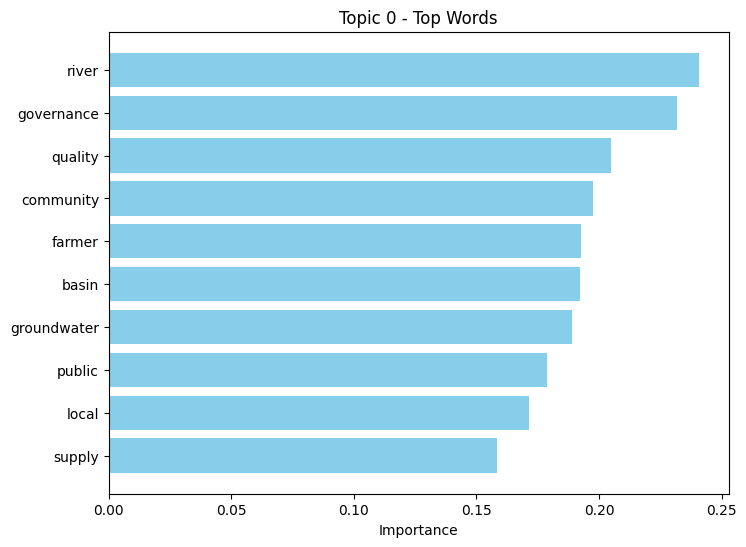

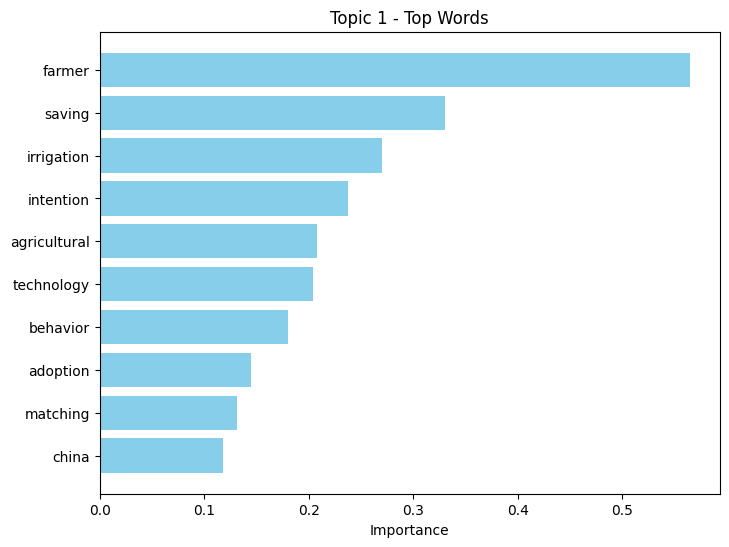

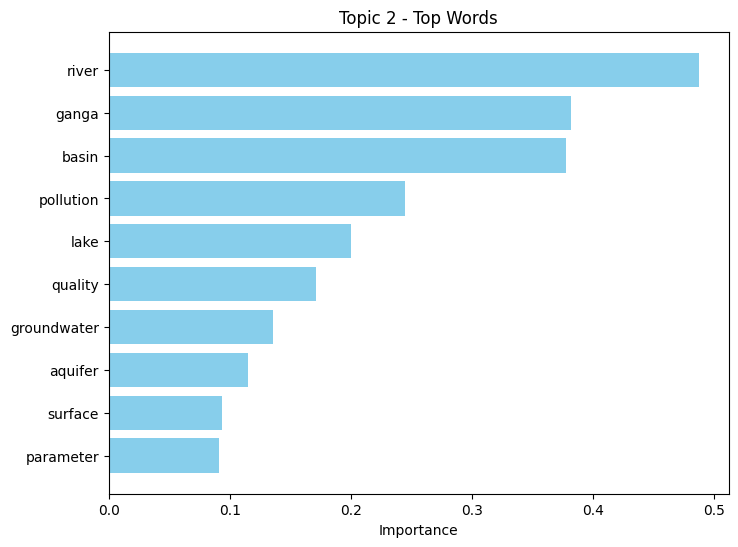

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Plot top words for each topic
num_words = 10
for topic_idx, topic in enumerate(H):
    top_words_idx = topic.argsort()[:-num_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_word_values = topic[top_words_idx]

    plt.figure(figsize=(8, 6))
    plt.barh(top_words, top_word_values, color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(f"Topic {topic_idx} - Top Words")
    plt.xlabel("Importance")
    plt.show()


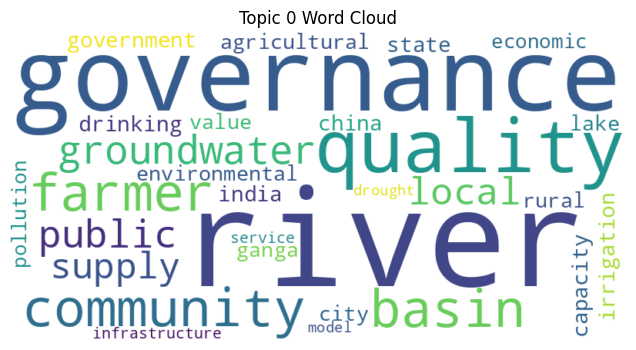

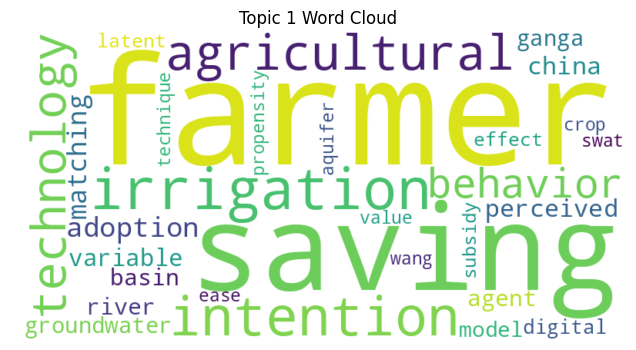

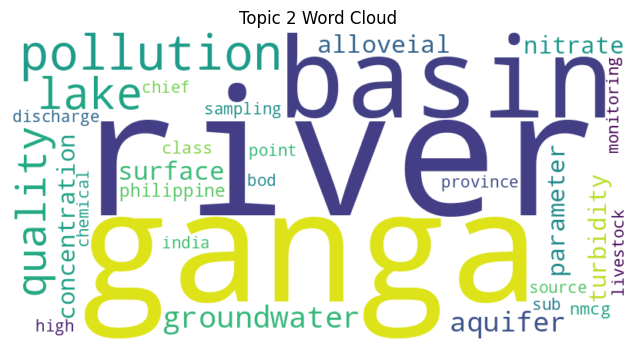

In [27]:
from wordcloud import WordCloud

# Generate word clouds for each topic
for topic_idx, topic in enumerate(H):
    top_words_idx = topic.argsort()[:-30 - 1:-1]  # Get top 30 words for word cloud
    top_words_freq = {feature_names[i]: topic[i] for i in top_words_idx}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_freq)

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_idx} Word Cloud")
    plt.show()


In [20]:
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# Convert lemmatized tokens into a list of lists format for gensim
tokenized_text = df['lemmatized_content'].tolist()

# Create a dictionary and corpus for gensim coherence model
dictionary = Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# Get topics from NMF model (list of words per topic)
nmf_topics = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]  # top 10 words for each topic
    top_words = [feature_names[i] for i in top_words_idx]
    nmf_topics.append(top_words)

# Initialize CoherenceModel with c_v metric
coherence_model_nmf = CoherenceModel(topics=nmf_topics, texts=tokenized_text, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_nmf.get_coherence()

print(f"NMF Model Coherence Score: {coherence_score}")


NMF Model Coherence Score: 0.6297928694406687


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Prepare and display the LDA visualization
lda_vis_data = gensimvis.prepare(best_lda_model, corpus_gensim, dictionary)
pyLDAvis.display(lda_vis_data)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


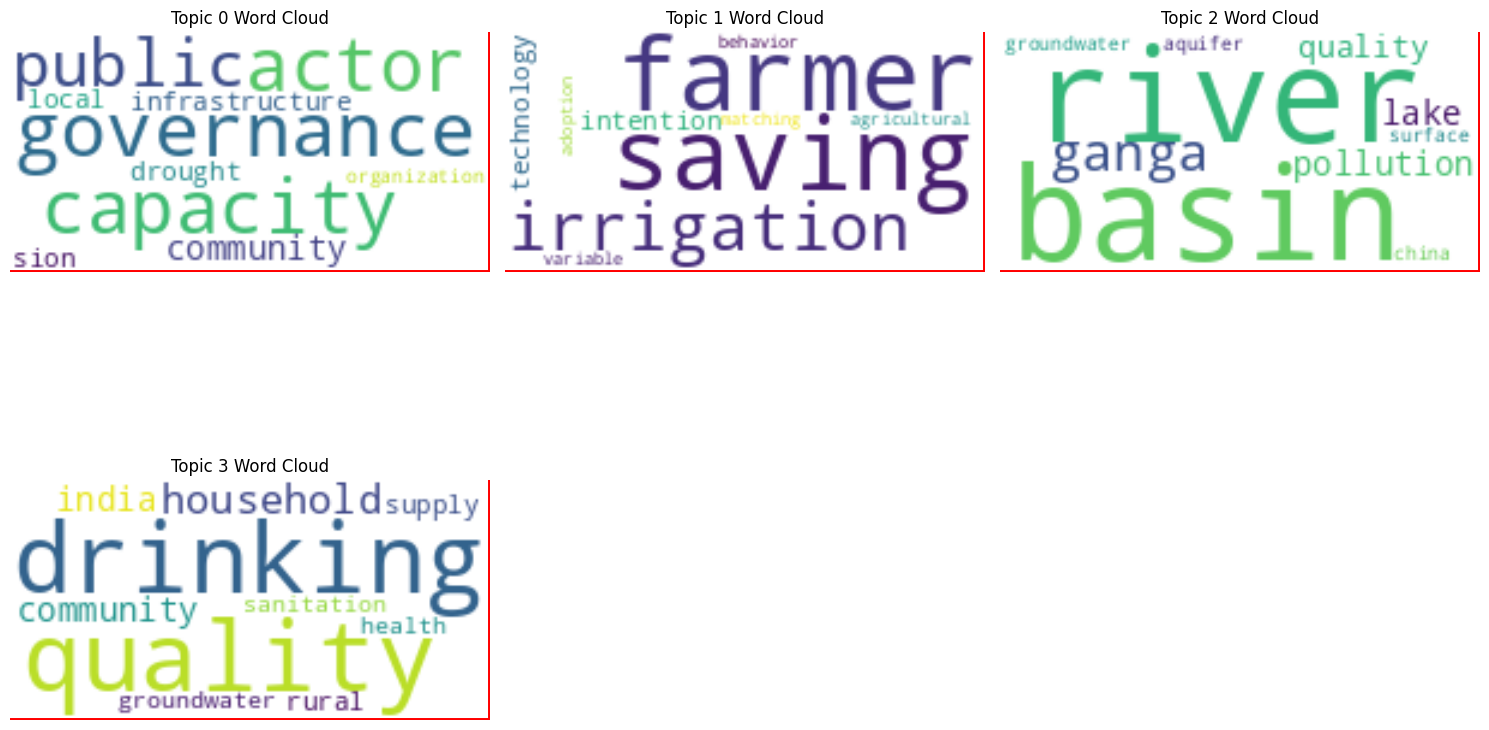

In [ ]:
# Visualizing evaluation Metric Score chart

# Create subplots for each topic's word cloud
plt.figure(figsize=(15, 10))
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    wordcloud = WordCloud(width=200, height=100, background_color='white').generate(' '.join(top_words))

    plt.subplot(2, 3, topic_idx + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_idx} Word Cloud")
    plt.gca().add_patch(plt.Rectangle((-20, -20), 220, 120, fill=None, edgecolor='red', linewidth=5))

plt.tight_layout()
#plt.savefig('wordclouds.png', dpi=300)  # Save the figure with higher DPI
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


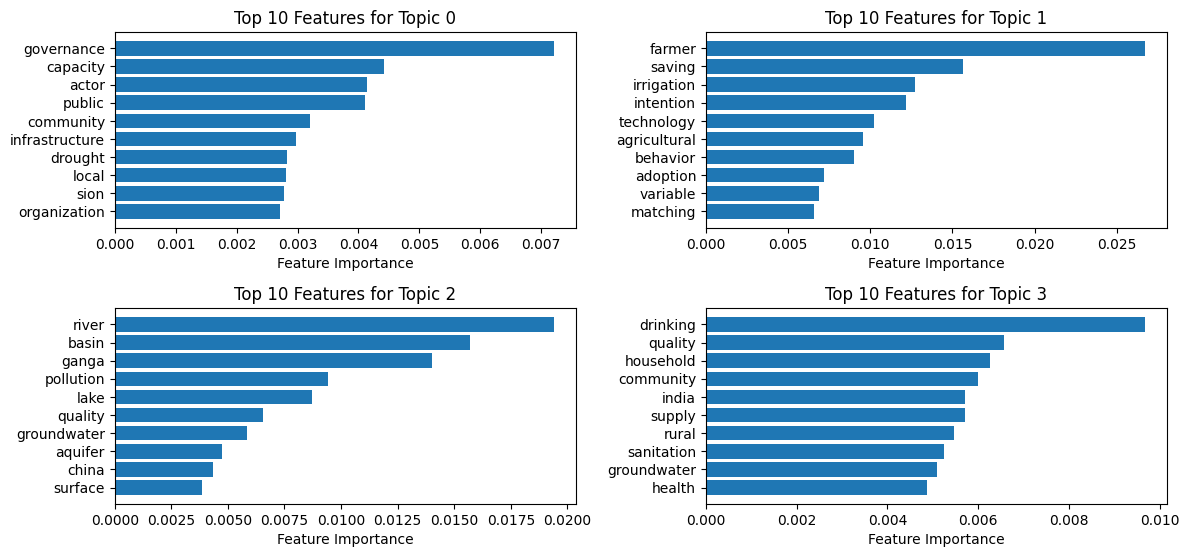

In [ ]:
components = nmf_model.components_

# normalize the components to sum to 1 for each topic
components /= components.sum(axis=1)[:, np.newaxis]

# Get the feature names
feature_names = feature_names

# Plot the top N important features for each topic
num_top_features = 10

# Create a 3x2 grid of subplots
num_topics = len(components)
num_rows = 3
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for topic_idx, topic in enumerate(components):
    row = topic_idx // num_cols
    col = topic_idx % num_cols

    top_feature_indices = topic.argsort()[:-num_top_features - 1:-1]
    top_features = [feature_names[i] for i in top_feature_indices]

    axes[row, col].barh(top_features, topic[top_feature_indices])
    axes[row, col].set_title(f"Top {num_top_features} Features for Topic {topic_idx}")
    axes[row, col].set_xlabel("Feature Importance")
    axes[row, col].invert_yaxis()  # Invert the order to show the most important feature at the top

# Remove empty subplots
for i in range(num_topics, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])
plt.tight_layout()
plt.show()


In [28]:
from sklearn.decomposition import TruncatedSVD
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# Define the parameter grid
topic_range = range(2, 10)  # Adjust the range as needed

# Prepare tokenized text and dictionary for coherence model
tokenized_text = df['lemmatized_content'].tolist()
dictionary = Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# Track best score and parameters
best_coherence = 0
best_num_topics = None

# Grid search over topic numbers
for num_topics in topic_range:
    # Initialize and fit the LSA model (TruncatedSVD)
    lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
    lsa_matrix = lsa_model.fit_transform(tfidf_matrix)

    # Extract topics from LSA model
    lsa_topics = []
    for topic_idx, topic in enumerate(lsa_model.components_):
        top_words_idx = topic.argsort()[:-10 - 1:-1]  # Get top 10 words
        top_words = [feature_names[i] for i in top_words_idx]
        lsa_topics.append(top_words)

    # Compute coherence score
    coherence_model_lsa = CoherenceModel(topics=lsa_topics, texts=tokenized_text, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lsa.get_coherence()

    # Update best score and parameters if current is better
    if coherence_score > best_coherence:
        best_coherence = coherence_score
        best_num_topics = num_topics

    print(f"Num Topics={num_topics} => Coherence Score: {coherence_score}")

print(f"\nBest Coherence Score: {best_coherence}")
print(f"Best Number of Topics: {best_num_topics}")


Num Topics=2 => Coherence Score: 0.568257507009721
Num Topics=3 => Coherence Score: 0.6272285032824131
Num Topics=4 => Coherence Score: 0.5880845806906198
Num Topics=5 => Coherence Score: 0.562046249260265
Num Topics=6 => Coherence Score: 0.5145573845192309
Num Topics=7 => Coherence Score: 0.5195902523464342
Num Topics=8 => Coherence Score: 0.5057013997880633
Num Topics=9 => Coherence Score: 0.4442307872977065

Best Coherence Score: 0.6272285032824131
Best Number of Topics: 3


In [29]:
# Initialize LSA model with the best number of topics (3)
best_lsa_model = TruncatedSVD(n_components=3, random_state=42)

# Fit the model on the TF-IDF matrix
best_lsa_matrix = best_lsa_model.fit_transform(tfidf_matrix)

# Display the topics and associated words
print("\nFinal LSA Topics and Top Words:")
for topic_idx, topic in enumerate(best_lsa_model.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]  # Get top 10 words
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")



Final LSA Topics and Top Words:
Topic 0: river, governance, quality, community, farmer, basin, groundwater, public, local, supply
Topic 1: farmer, saving, irrigation, intention, agricultural, technology, behavior, adoption, matching, china
Topic 2: river, ganga, basin, pollution, lake, quality, groundwater, aquifer, surface, alloveial
